<a href="https://colab.research.google.com/github/kubenko-k/Spatial-project/blob/main/Clustering/EdgeR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scanpy


In [ ]:
pip install squidpy

In [ ]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import squidpy as sq
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir_path = '/content/drive/My Drive/Skoltech/Spatial_project/'
dir_path_er = '/content/drive/My Drive/Skoltech/Spatial_project/EdgeR/'
dir_path_r = '/content/drive/My Drive/Skoltech/Spatial_project/Raw/'


#Nice pictures

In [ ]:
adata_nb = sc.read_h5ad(dir_path_r + 'human.h5ad')
adata_nb.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
sc.pp.normalize_total(adata_nb)
sc.pp.log1p(adata_nb)

In [ ]:
scaled_adata_list = list()
for sample in adata_nb.obs.sample_id.unique():
    scaled_adata_list.append(sc.pp.scale(adata_nb[adata_nb.obs.sample_id == sample], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

In [ ]:
labels = pd.read_csv(dir_path + 'genes_by_cluster.csv')
labels = labels.rename(columns={'Unnamed: 0': "gene"})
labels.index = labels['gene']
labels = labels.drop('gene', axis = 1)
labels

In [ ]:
labels = labels.rename_axis('gene')

cluster_dict = {f"cluster{i}": [] for i in range(8)}

# Iterate over each row of the DataFrame and populate the dictionary
for gene, cluster in labels.iterrows():
    cluster_dict[f"cluster{cluster['cluster']}"].append(gene)

# Print the resulting dictionary
print(cluster_dict)

In [ ]:
genes = cluster_dict['cluster5']
genes

In [ ]:
for cluster in cluster_dict.keys():
    genes = cluster_dict[cluster]
    scaled_adata.obs[f'{cluster}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

In [ ]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)

sq.pl.spatial_scatter(scaled_adata,
                      color=['cluster0_scaled', 'cluster1_scaled', 'cluster2_scaled', 'cluster3_scaled', 'cluster4_scaled', 'cluster5_scaled', 'cluster6_scaled', 'cluster7_scaled', 'label'],
                      library_key='sample_id', ncols=9, img=True, size=2, cmap=cmap, norm=norm)

In [ ]:
adata_ad = sc.read_h5ad(dir_path_r + 'spatial_libd_human.h5ad')
adata_ad.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
adata_ad = adata_ad[:, labels.index]
sc.pp.normalize_total(adata_ad)
sc.pp.log1p(adata_ad)

In [ ]:
adata_ad = adata_ad[:, labels.index]
adata_ad

In [ ]:
scaled_adata_list = list()
for sample in adata_ad.obs.sample_id.unique():
    scaled_adata_list.append(sc.pp.scale(adata_ad[adata_ad.obs.sample_id == sample], copy=True))

scaled_adata = an.concat(scaled_adata_list , merge='same',uns_merge="unique")
scaled_adata

In [ ]:
del adata_ad

In [ ]:
del labels

In [ ]:
for cluster in cluster_dict.keys():
    genes = cluster_dict[cluster]
    scaled_adata.obs[f'{cluster}_scaled'] = scaled_adata[:, genes].X.mean(axis=1)
scaled_adata.obs.head()

In [ ]:
del dir_path_r

In [ ]:
cmap = mpl.cm.coolwarm
norm = mpl.colors.TwoSlopeNorm(vcenter=0)

sq.pl.spatial_scatter(scaled_adata,
                      color=['cluster0_scaled', 'cluster1_scaled', 'cluster2_scaled', 'cluster3_scaled', 'cluster4_scaled', 'cluster5_scaled', 'cluster6_scaled', 'cluster7_scaled', 'label'],
                      library_key='sample_id', ncols=9, img=True, size=2, cmap=cmap, norm=norm)

#Normalization

Samples were normalized by logarithm of library size. As the samples came from two different experiments and could result in batch-effect, they were additionally normalized by mean - mean expression across all samples for each of the genes was extracted from each of the genes in each sample.

In [ ]:
adata_nb = sc.read_h5ad(dir_path_r + 'human.h5ad')
adata_nb.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
sc.pp.normalize_total(adata_nb)
sc.pp.log1p(adata_nb)

In [ ]:
pb_age = sc.read_h5ad(dir_path + 'pb_age.h5ad')
pb_age.obs["lib_size"] = pb_age.X.sum(axis=1)
pb_age.obs["log_lib_size"] = np.log(pb_age.obs["lib_size"])
sc.pp.normalize_total(pb_age, target_sum=1e4)
sc.pp.log1p(pb_age)
pb_age = pb_age[:, pb_age.X.mean(axis=0) > 0.05]


In [ ]:
def mean (adata):
    pb_df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
    pb_df['sample_id'] = adata.obs['sample_id']
    pb_df['sample_id'].replace({'151507': '1', '151508':'1', '151509' : '1', '151510' : '1', '151669' : '2', '151670':'2', '151671':'2', '151672':'2', '151673':'3', '151674':'3', '151675':'3', '151676':'3'}, inplace=True)
    pb_df.head()
    sample_mean = pb_df.groupby('sample_id').mean()
    columns = pb_df.columns.tolist()[:-1]
    for sample in tqdm(sample_mean.index.tolist()):
        pb_df.loc[pb_df.sample_id == sample, columns] = (pb_df.loc[pb_df.sample_id == sample, columns] - sample_mean.loc[sample])

    adata.X = pb_df[columns].values
    return adata

In [ ]:
pb_age_norm_mean = mean (pb_age)

In [ ]:
df_mean = pd.DataFrame(pb_age_norm_mean.X, index=pb_age_norm_mean.obs_names, columns=pb_age_norm_mean.var_names)
df_mean['condition'] = pb_age_norm_mean.obs.condition
df_mean['layer'] = pb_age_norm_mean.obs.layer
df_mean = df_mean.T
df_mean

In [ ]:
df_res = df_mean[df_mean.index.isin(edge_r.gene)]
df_res = df_res.T
df_res

In [ ]:
df = df.T
df['sample_id'] = pb_age_norm.obs['sample_id']

In [ ]:

df['sample_id'].replace({'151507': '1', '151508':'1', '151509' : '1', '151510' : '1', '151669' : '2', '151670':'2', '151671':'2', '151672':'2', '151673':'3', '151674':'3', '151675':'3', '151676':'3'}, inplace=True)
df

In [ ]:
edge_r = pd.read_csv(dir_path_er + 'sig_edger.csv')
pb_age_norm = sc.read_h5ad(dir_path + 'pb_age_norm.h5ad')
df = pd.DataFrame(pb_age_norm.X, index=pb_age_norm.obs_names, columns=pb_age_norm.var_names)
df = df.T
df_res = df[df.index.isin(edge_r.gene)]
df_res = df_res.T
df_res

In [ ]:
df_res = df_mean[df_mean.index.isin(edge_r.gene)]
df_res = df_res.T
df_res

In [ ]:
FC = pd.read_csv(dir_path + "FC.csv")
FC.columns = FC.columns.str.replace('Unnamed: 0','genes')
FC

In [ ]:
df = df_mean


In [ ]:
df_res = df_res.apply(pd.to_numeric)


#Clusterization

 Differentially expressed genes were hierarchically clustered based on their normalized expression in order to identify potential number of gene clusters.

In [ ]:
sample_order = dict()
for cond in ['human', '151']:
    samples = df_res.loc[df_res.index.str.contains(cond)].index
    order = samples.sort_values()
    order_laminar = order[order.str.contains('L')].tolist()
    order_wm = order[order.str.contains('WM')].tolist()
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['151']
df_res = df_res.loc[sample_order['all']]
sns.set(font_scale=0.7)
g = sns.clustermap(df_res, figsize=(15, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

In [ ]:
g.fig.savefig('heatmap_hrch.png', dpi=300, bbox_inches='tight')
plt.close(g.fig)

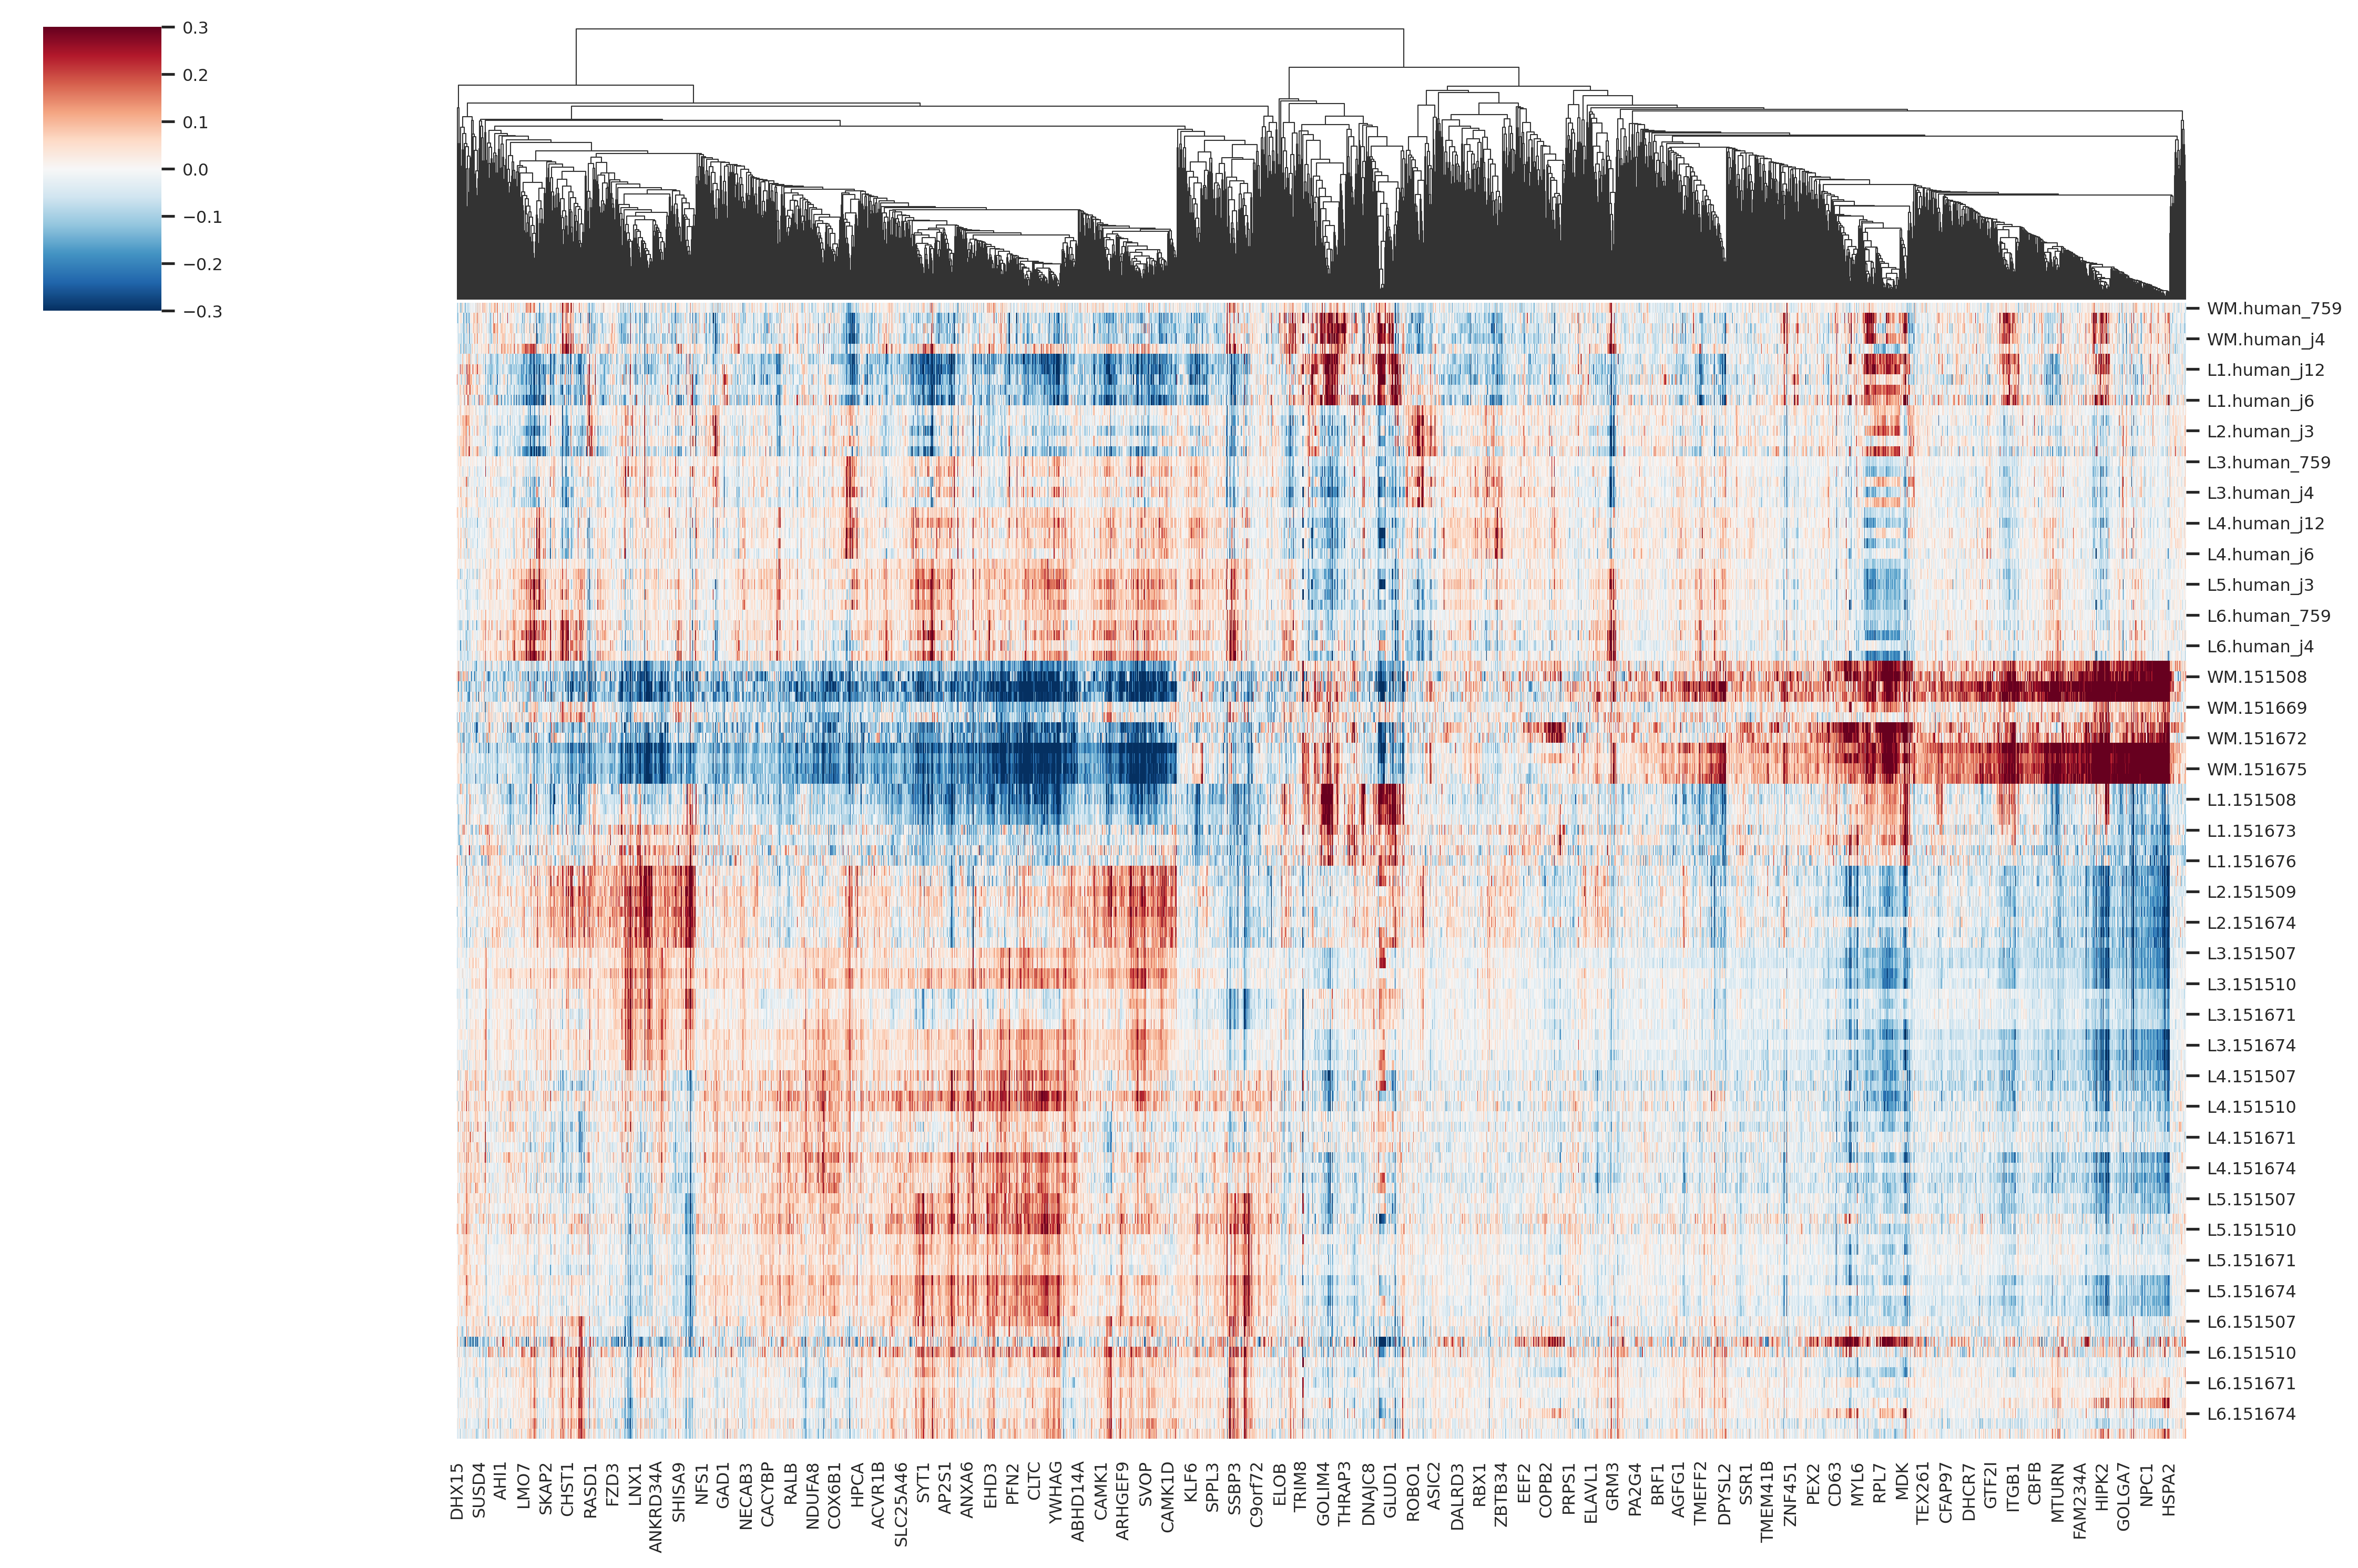

 Next the same genes were clustered by spectral clustering. The number of clusters was chosen based on results of hierarchical clustering.


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_res.T, metric='cosine') + 2
n_clusters = 8
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)
cl_order = {i: a for i, a in enumerate([0, 1, 2, 3, 4, 5, 6, 7])}
labels = pd.Series(clustering.labels_, index=df_res.columns).map(cl_order).sort_values()
order = labels.sort_values().index
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_res.loc[sample_order['all'], order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)

In [ ]:
fig.savefig('heatmap_clstrl.png', dpi=300, bbox_inches='tight')
plt.close(fig)

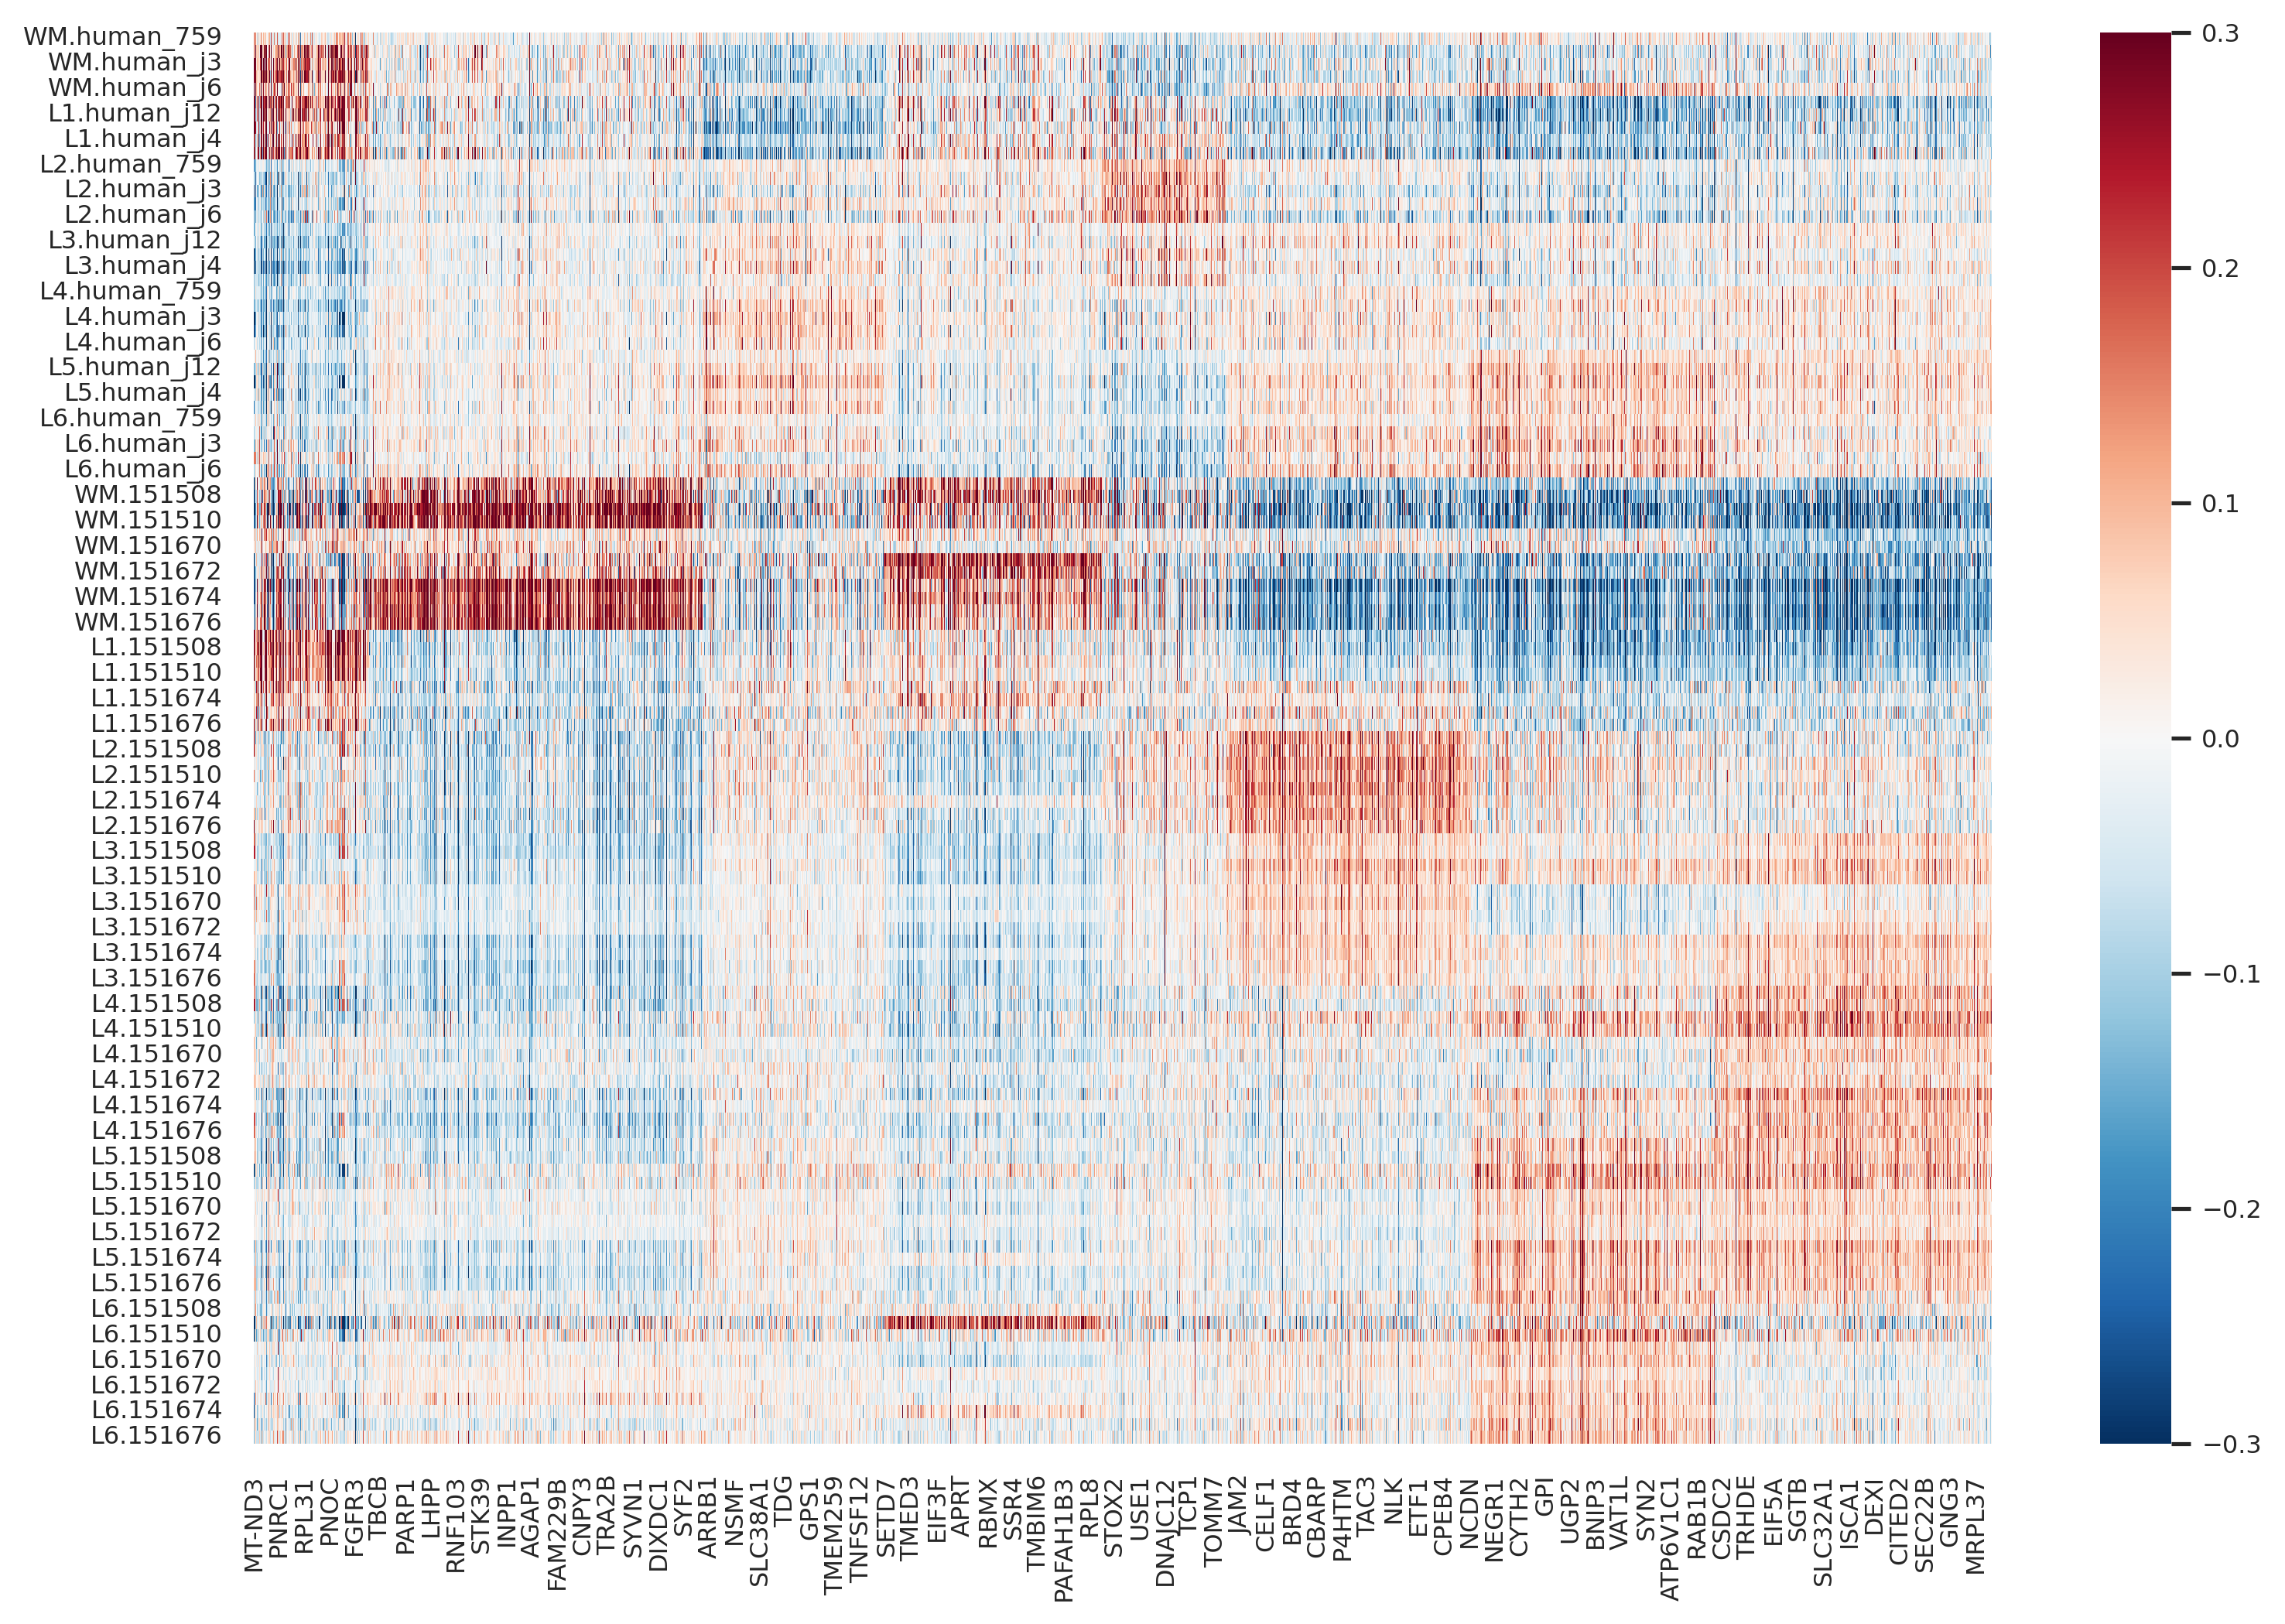

In [ ]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']
cluster_color = ['red', 'blue', 'green',  'yellow', 'orange', 'purple', 'olive', 'pink', 'brown', 'black']
clusters_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

clusters = np.arange(n_clusters)
colors = cluster_color[:n_clusters]
fig, axes = plt.subplots(7, 1, figsize=(12, 4 * n_clusters), gridspec_kw={'hspace': 0.2})

for ax, layer in zip(axes.flatten(), ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'WM']):
    df_layer = df_res.loc[df_res.index.str.contains(layer)]
    sns.heatmap(df_layer.loc[:, order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0, xticklabels=False)
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='5%', pad=0.05)
    cmap = mpl.colors.ListedColormap(colors)

    cluster_size = labels.value_counts().loc[clusters].values
    cluster_pos = cluster_size.cumsum()
    bounds = [0] + list(cluster_pos)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=cax,
        ticks=bounds,
        orientation='horizontal',
        spacing='proportional'
    )
    cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
    cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
    cax.xaxis.tick_top()

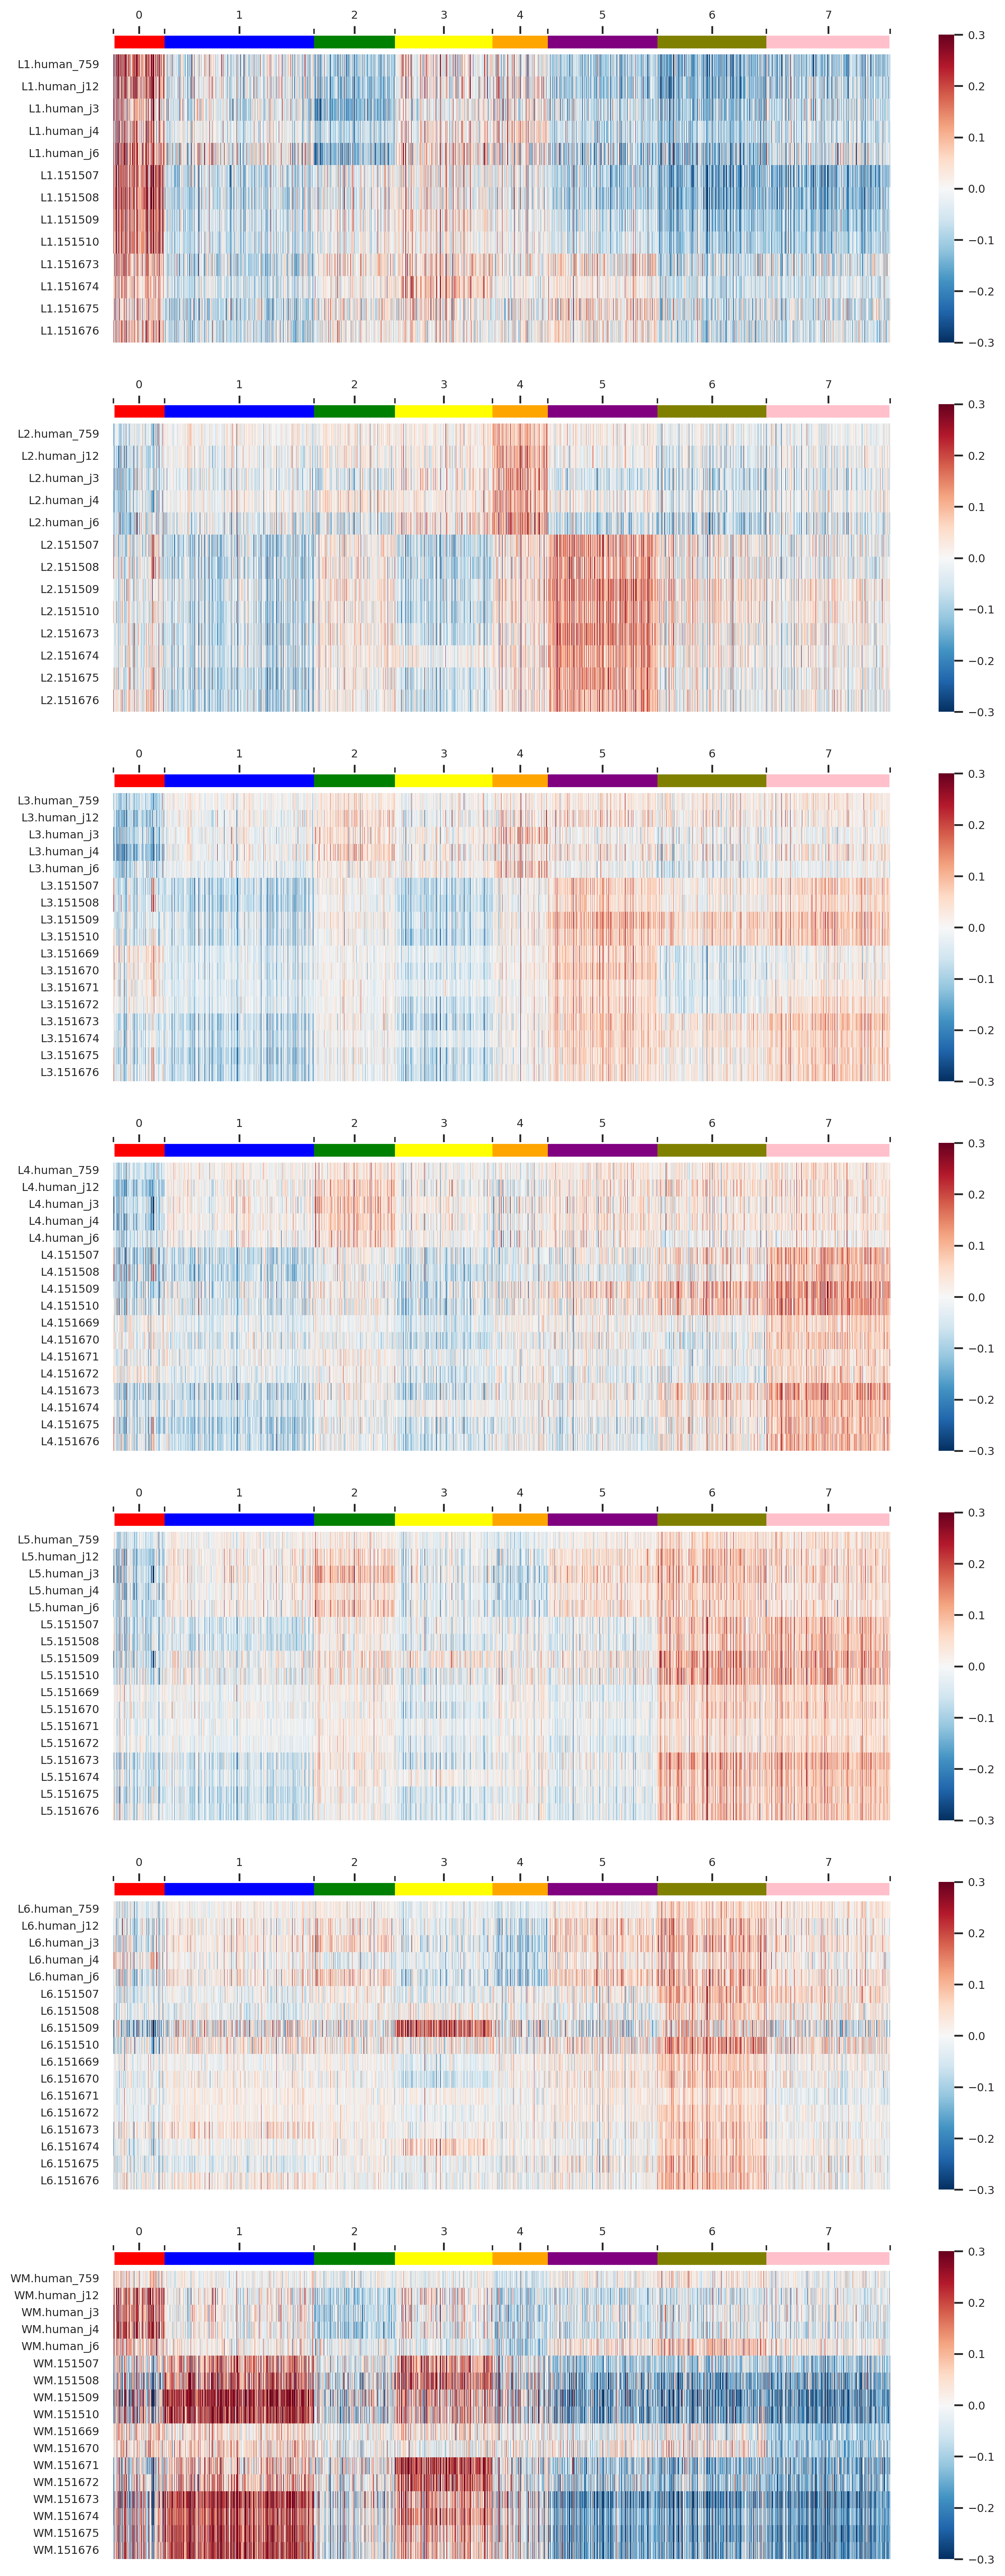

For each of the 8 identified clusters average expression for each of the cortical layers was calculated and expression profiles were plotted.


In [ ]:
df_annotation = df_res.copy()
df_annotation['layer'] = pb_age_norm.obs.layer
df_annotation['condition'] = pb_age_norm.obs.condition
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()
fig, axes = plt.subplots(n_clusters // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})

for label, ax in zip(clusters, axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:purple', 'spatial_libd_human': 'tab:orange'}, ax=ax, marker='.')
    )
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [ ]:
fig.savefig('clusters.png', dpi=300, bbox_inches='tight')
plt.close(fig)

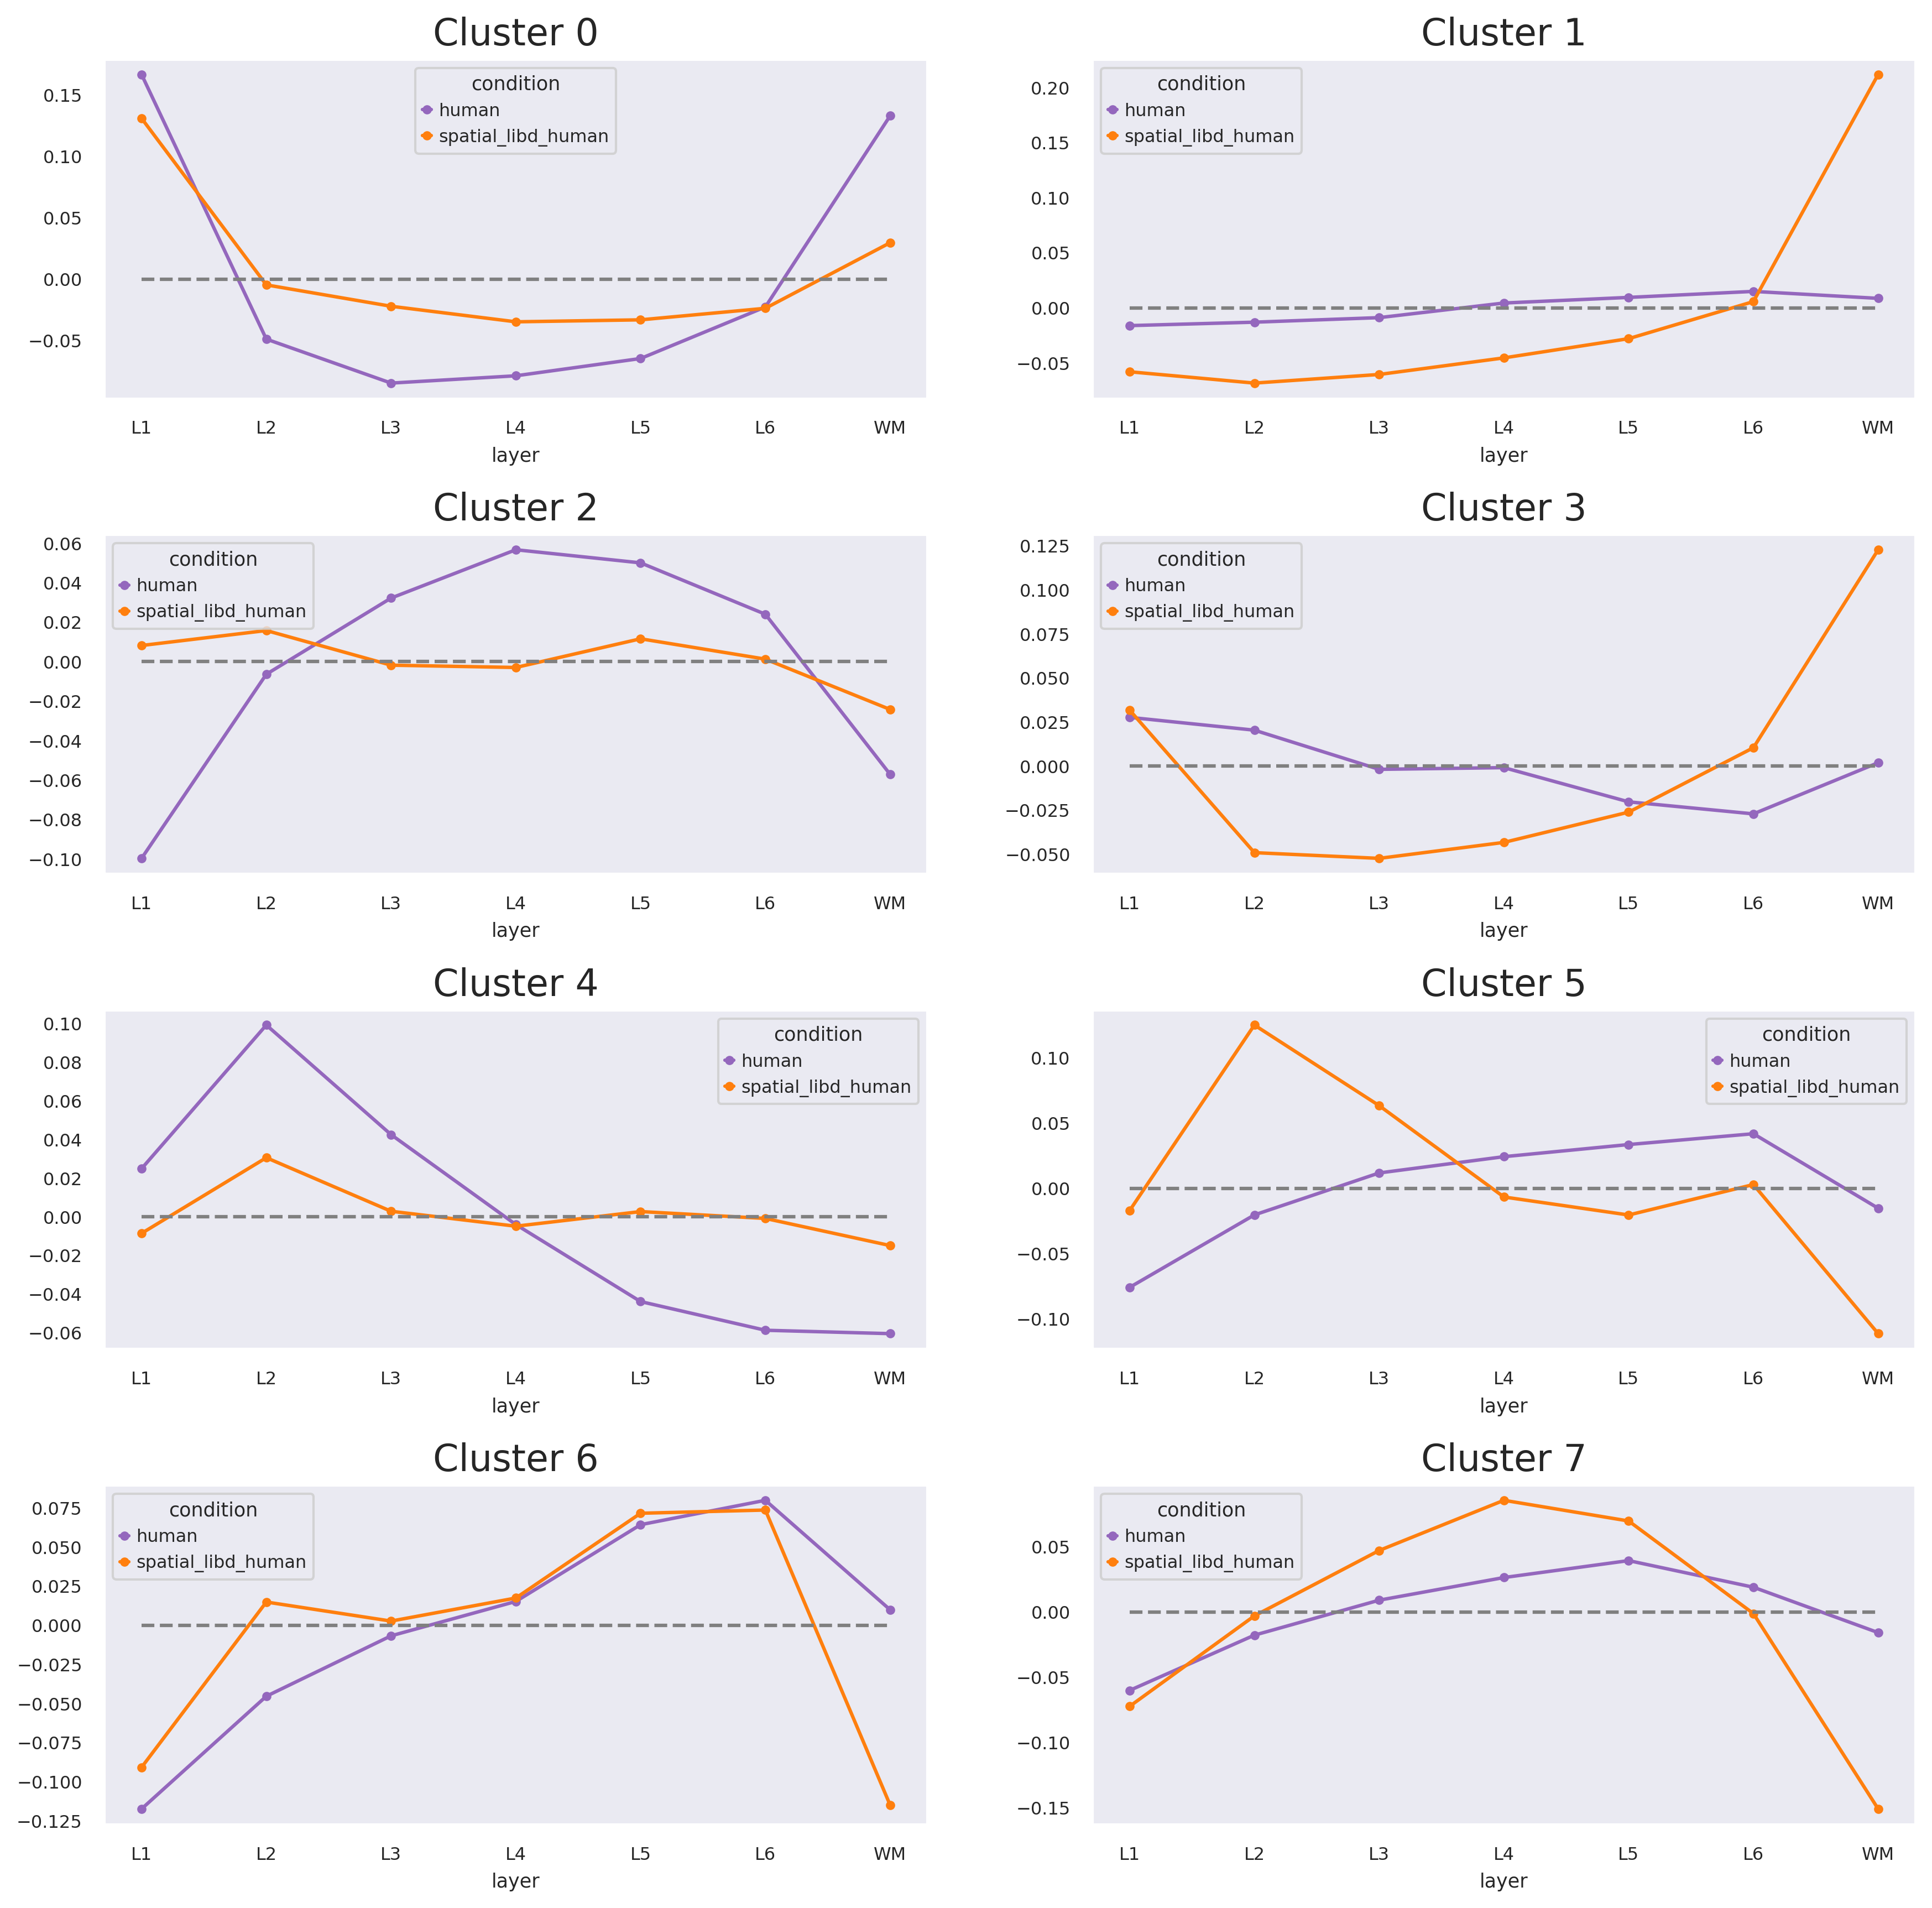

In [ ]:
labels = pd.DataFrame(labels)

In [ ]:
labels = labels.rename(columns={0: "cluster"})
labels

In [ ]:
labels.to_csv(dir_path + 'genes_by_cluster.csv')

In [ ]:
pip install gseapy


In [ ]:
import gseapy
from gseapy import barplot, dotplot

In [ ]:
list(labels['cluster'])

In [ ]:
for i in labels['cluster']:

  enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == i].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
  enr_res = enr.results
  enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]



In [ ]:
 dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=15,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
labels.index = labels['gene']
labels

In [ ]:
labels.index = labels['gene']
labels = labels.drop('gene', axis = 1)
labels

In [ ]:
enr_res

##Cluster 0

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=15,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_0 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_0['cluster'] = '0'
enr_res_0

##Cluster 1

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_1 = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res_1,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_1 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_1['cluster'] = '1'
enr_res_1

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_2 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_2['cluster'] = '2'
enr_res_2

In [ ]:
cluster_id = 3
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_3 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_3['cluster'] = '3'
enr_res_3

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_4 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_4['cluster'] = '4'
enr_res_4

In [ ]:
cluster_id = 5
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_5 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_5['cluster'] = '5'
enr_res_5

In [ ]:
cluster_id = 6
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_6 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_6['cluster'] = '6'
enr_res_6

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res_7 = enr_res[enr_res['Adjusted P-value'] < 0.05]
enr_res_7['cluster'] = '7'
enr_res_7

In [ ]:
enr_res_0 = enr_res_0.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_0 = enr_res_0.head(5)

enr_res_1 = enr_res_1.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_1 = enr_res_1.head(5)

enr_res_2 = enr_res_2.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_2 = enr_res_2.head(5)

enr_res_3 = enr_res_3.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_3 = enr_res_3.head(5)

enr_res_4 = enr_res_4.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_4 = enr_res_4.head(5)

enr_res_5 = enr_res_5.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_5 = enr_res_5.head(5)

enr_res_6 = enr_res_6.sort_values(by = 'Adjusted P-value', ascending = True)
enr_res_6 = enr_res_6.head(5)

In [ ]:
enrich_res = pd.concat([enr_res_0, enr_res_1, enr_res_2, enr_res_3, enr_res_4, enr_res_5, enr_res_6, enr_res_7])
enrich_res

In [ ]:
fig = plt.figure(figsize=(7, 13), dpi=100)

ax = sns.scatterplot(
    data=enrich_res,
    x='cluster',
    y='Term',
    hue='Adjusted P-value',
    palette = 'winter',
    sizes=(200)
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
edge_r

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

##Cluster 2

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

##Cluster 3

In [ ]:
cluster_id = 3
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
cluster_id = 3
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 3
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 3
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

##CLuster 4

In [ ]:
labels_4 = labels.loc[labels.cluster == 4]
labels_4

In [ ]:
labels

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['DisGeNET'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

##Cluster 5

In [ ]:
cluster_id = 5
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
cluster_id = 5
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=15,
              figsize=(10,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 5
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 5
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 5
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['DisGeNET'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

##Cluster 6

In [ ]:
cluster_id = 6
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 6
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=15,
              figsize=(10,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 6
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 6
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 6
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['DisGeNET'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
df

##Cluster 7

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = df.index,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
edge_r.gene

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['SynGO_2022'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Azimuth_Cell_Types_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(3,5),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Disease_Perturbations_from_GEO_down',
                                'Disease_Perturbations_from_GEO_up',
                                'Disease_Signatures_from_GEO_down_2014',
                                'Disease_Signatures_from_GEO_up_2014'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Rare_Diseases_AutoRIF_ARCHS4_Predictions',
                                'Rare_Diseases_GeneRIF_ARCHS4_Predictions'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
GNAZ;CADM1;FAXC;MAST1;LSAMP;CELF5;CRMP1;STMN4;DISP2;FAM171A2;TUBB2B;CAMKV;TUBB3;LHX2;DDAH2;GNG4;DPYSL3;MAP6;XKR4;CNIH2;SCN3A


In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO',
                                'RNAseq_Automatic_GEO_Signatures_Human_Down',
                                'RNAseq_Automatic_GEO_Signatures_Human_Up'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['RNA-Aging_Perturbations_from_GEO_down',
                                'Aging_Perturbations_from_GEO_up'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 7
enr = gseapy.enrichr(gene_list = list(labels[labels['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['Allen_Brain_Atlas_10x_scRNA_2021',
                                'Allen_Brain_Atlas_down',
                                'Allen_Brain_Atlas_up'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
de_fc_7_citp = de_fc_7.loc[['GNAZ', 'CADM1', 'FAXC', 'MAST1', 'LSAMP', 'CELF5', 'CRMP1', 'STMN4', 'DISP2', 'FAM171A2', 'TUBB2B', 'CAMKV', 'TUBB3', 'LHX2', 'DDAH2', 'GNG4', 'DPYSL3', 'MAP6', 'XKR4', 'CNIH2'], :]
de_fc_7_citp

In [ ]:
de_fc_7_ntum = de_fc_7.loc[['TUB', 'HDAC5', 'SDC3', 'CACNA1B', 'PPP2R5B', 'CRMP1', 'STMN4', 'VASH1', 'DUSP8', 'KLF7', 'TUBB2B', 'MAP1LC3A', 'TUBB3', 'MCRIP1', 'DNAJB5', 'GPRIN1', 'DPYSL3', 'NCS1', 'SFXN3', 'TIMP2', 'CTSF'], :]
de_fc_7_ntum

In [ ]:
de_fc_7_xpvh = de_fc_7.loc[['PODXL2', 'THRA', 'CTNND2', 'MLLT1', 'AGAP3', 'ADCY1', 'CHD3', 'PDZD4', 'FAM171A2', 'DPYSL3', 'NCS1', 'PLXNA1', 'SBF1', 'TNPO2', 'SPTBN1', 'ZBTB18', 'PPP2R5B', 'CSNK1E', 'AP2B1', 'DUSP8', 'PRRC2B', 'SREBF2', 'ARHGAP33', 'ADGRB2', 'GPRIN1', 'FAM131B'], :]
de_fc_7_xpvh

In [ ]:
de_fc_7_ntum = de_fc_7.loc[['TUB', 'HDAC5', 'SDC3', 'CACNA1B', 'PPP2R5B', 'CRMP1', 'STMN4', 'VASH1', 'DUSP8', 'KLF7', 'TUBB2B', 'MAP1LC3A', 'TUBB3', 'MCRIP1', 'DNAJB5', 'GPRIN1', 'DPYSL3', 'NCS1', 'SFXN3', 'TIMP2', 'CTSF'], :]
de_fc_7_ntum

In [ ]:
de_fc_7_citp = de_fc_7.loc[['GNAZ'], :]
de_fc_7_citp

In [ ]:
de_fc_7

In [ ]:
cluster_7

#FC analysis

In [ ]:
df_res_t = df_res.T
df_res_t['genes'] = df_res_t.index
de_fc = pd.merge(FC, df_res_t, on='genes', how='inner')
de_fc = de_fc.drop(de_fc.iloc[:, 8:119], axis = 1)
de_fc.index = de_fc['genes']
de_fc = de_fc.drop(de_fc.columns[0], axis =1)
de_fc = de_fc.sort_values(by = 'FC_L1', ascending = False)
de_fc = de_fc.dropna(axis = 0)
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

In [ ]:
cluster_2 = labels.loc[labels.cluster == 2]
cluster_1 = labels.loc[labels.cluster == 1]
cluster_0 = labels.loc[labels.cluster == 0]
cluster_3 = labels.loc[labels.cluster == 3]
cluster_4 = labels.loc[labels.cluster == 4]
cluster_5 = labels.loc[labels.cluster == 5]
cluster_6 = labels.loc[labels.cluster == 6]
cluster_7 = labels.loc[labels.cluster == 7]
de_fc_0 = de_fc.loc[de_fc.index.isin(cluster_0.index)]
de_fc_1 = de_fc.loc[de_fc.index.isin(cluster_1.index)]
de_fc_2 = de_fc.loc[de_fc.index.isin(cluster_2.index)]
de_fc_3 = de_fc.loc[de_fc.index.isin(cluster_3.index)]
de_fc_4 = de_fc.loc[de_fc.index.isin(cluster_4.index)]
de_fc_5 = de_fc.loc[de_fc.index.isin(cluster_5.index)]
de_fc_6 = de_fc.loc[de_fc.index.isin(cluster_6.index)]
de_fc_7 = de_fc.loc[de_fc.index.isin(cluster_7.index)]
de_fc_7

In [ ]:
de_fc_2 = de_fc_2.sort_values(by = 'FC_L1', ascending = False)
de_fc_2.head(100)

In [ ]:
SF3B4 = de_fc_2.loc[de_fc_2.index == 'SF3B4']
SF3B5 = de_fc_2.loc[de_fc_2.index == 'SF3B5']
SNRPD1 = de_fc_2.loc[de_fc_2.index == 'SNRPD1']
SNRNP70 = de_fc_2.loc[de_fc_2.index == 'SNRNP70']
MAGOH = de_fc_2.loc[de_fc_2.index == 'MAGOH']
DHX15 = de_fc_2.loc[de_fc_2.index == 'DHX15']
LSM5 = de_fc_2.loc[de_fc_2.index == 'LSM5']
LSM5

In [ ]:
enr_res

In [ ]:
de_fc_7 = de_fc_7.sort_values(by = 'FC_L1', ascending = False)
de_fc_7.head(100)

In [ ]:
fc_7 = edge_r.loc[edge_r.gene.isin(de_fc_7.index)]
fc_7 = fc_7.sort_values(by ='logFC.ns.layer..df...3.1.spatial_libd_human', ascending = False)
fc_7.head(50)

In [ ]:
MYT1L = de_fc_7.loc[de_fc_7.index == 'MYT1L']
RBFOX1 = de_fc_7.loc[de_fc_7.index == 'RBFOX1']
GDA = de_fc_7.loc[de_fc_7.index == 'GDA']
GDA

In [ ]:
fc_2 = edge_r.loc[edge_r.gene.isin(de_fc_2.index)]
fc_2 = fc_2.sort_values(by ='logFC.ns.layer..df...3.1.spatial_libd_human', ascending = False)
fc_7.head(50)

##Cluster 0

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_0, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

In [ ]:
de_fc_0.head(20)

##Cluster 1

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_1, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

##Cluster 2

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_2, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

##Cluster 3

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_3, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

##Cluster 4

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_4, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

In [ ]:
de_fc_4.head(20)

##Cluster 5

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_5, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

##Cluster 6

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_6, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

In [ ]:
de_fc_6.sort_values(by = 'FC_L2')

In [ ]:
de_fc_6.head(20)

##Cluster 7

In [ ]:
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc_7, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

In [ ]:
de_fc_7_down = de_fc_7.loc[(de_fc_7.FC_L2 < 0)]
de_fc_7_down

In [ ]:
de_fc_7_up.index

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(de_fc_7_up.index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2021',
                                'GO_Cellular_Component_2021',
                                'GO_Molecular_Function_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=15,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

#Additional analysis based on FC

##Cluster 0

In [ ]:
de_fc_0_sub = de_fc_0.loc[de_fc_0.FC_L1 > 0]
de_fc_0_sub = de_fc_0_sub.loc[de_fc_0_sub.FC_L4 < 0]
de_fc_0_sub

In [ ]:
de_fc_7_sub = de_fc_7.loc[de_fc_7.FC_L1 < 0]
de_fc_7_sub = de_fc_7_sub.loc[de_fc_7_sub.FC_L5 > 0]
de_fc_7_sub

In [ ]:
df_res_PEG3

In [ ]:
df_res_PEG3 = df_res_t.loc[df_res_t.index == 'PEG3']
df_res_PEG3 = df_res_PEG3.T
df_annotation = df_res_PEG3.copy()
df_annotation['layer'] = pb_age_norm.obs.layer
df_annotation['condition'] = pb_age_norm.obs.condition
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean = layer_mean.reset_index()
sns.lineplot(data = layer_mean, x = 'layer', y = 'PEG3', hue = 'condition')

In [ ]:
df_t = df.T
df_t['condition'] = pb_age_norm.obs.condition
df_t['layer'] = pb_age_norm.obs.layer

In [ ]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.boxplot(ax = ax, data = df_t, y = 'SOBP', x = 'layer', hue = 'condition')

#GSEA

In [ ]:
edge_r = pd.read_csv(dir_path_er + 'edgeR_age_sampleid.csv')
edge_r

In [ ]:
edge_r.columns = edge_r.columns.str.replace('Unnamed: 0','gene')
mult_test = multipletests(edge_r['PValue'], method='fdr_bh')
edge_r['p_val_adj'] = mult_test[1]
edge_r

In [ ]:
sns.set_theme(style = 'white')
sns.histplot(data=edge_r, x = 'p_val_adj', color = 'g')

In [ ]:
 pip install gseapy

In [ ]:
from gseapy import barplot, dotplot
import gseapy as gp


In [ ]:
edgeR = edgeR.sort_values(by = 'p_val_adj')
edgeR

In [ ]:
edgeR = edgeR.drop(edgeR.columns[1:7], axis =1)
edgeR.index = edgeR.gene
edgeR

In [ ]:
edgeR = edgeR.drop(edgeR.columns[0], axis =1)
edgeR

In [ ]:
pre_res = gp.prerank(rnk= edgeR, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2023',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

In [ ]:
pre_res.res2d.sort_values(by = 'FDR q-val')


In [ ]:
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             title='GO_Biological_Process_2023',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(10,15), cutoff=0.25, show_ring=False)

In [ ]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[4])

In [ ]:
cluster_0

#Additional clustertization of clusters

In [ ]:
df_res_0 = df[df.index.isin(cluster_0.index)]
df_res_1 = df[df.index.isin(cluster_1.index)]
df_res_2 = df[df.index.isin(cluster_2.index)]
df_res_3 = df[df.index.isin(cluster_3.index)]
df_res_4 = df[df.index.isin(cluster_4.index)]
df_res_5 = df[df.index.isin(cluster_5.index)]
df_res_6 = df[df.index.isin(cluster_6.index)]
df_res_7 = df[df.index.isin(cluster_7.index)]

In [ ]:
df_res

In [ ]:
df = df_res.T
df = df.apply(pd.to_numeric)
df

In [ ]:
df_res_0

In [ ]:
df_res_0 = df_res_0.T


##0

In [ ]:
sample_order = dict()
for cond in ['human', '151']:
    samples = df_res_0.loc[df_res_0.index.str.contains(cond)].index
    order = samples.sort_values()
    order_laminar = order[order.str.contains('L')].tolist()
    order_wm = order[order.str.contains('WM')].tolist()
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['151']
df_res_0 = df_res_0.loc[sample_order['all']]
sns.set(font_scale=0.7)
sns.clustermap(df_res_0, figsize=(15, 10), cmap="RdBu_r", center=0, vmax=0.25, vmin=-0.25, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_res_0.T, metric='cosine') + 2
n_clusters = 2
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)
cl_order = {i: a for i, a in enumerate([0, 1])}
labels = pd.Series(clustering.labels_, index=df_res_0.columns).map(cl_order).sort_values()
order = labels.sort_values().index
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(12, 8))
y = sns.heatmap(df_res_0.loc[sample_order['all'], order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)

In [ ]:
df_annotation = df_res_0.copy()
df_annotation['layer'] = pb_age_norm.obs.layer
df_annotation['condition'] = pb_age_norm.obs.condition
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()
fig, axes = plt.subplots(n_clusters // 1, 1,  figsize=(7, 6 * n_clusters // 2), gridspec_kw={'hspace': 0.4})

for label, ax in zip(clusters, axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:purple', 'spatial_libd_human': 'tab:orange'}, ax=ax, marker='.')
    )
    ax.set_title(f'Cluster {label}', fontsize=12)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [ ]:
labels_0 = pd.DataFrame(labels)
labels_0 = labels_0.rename(columns={0: "cluster"})

labels_0

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels_0[labels_0['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels_0[labels_0['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_0_0 = labels_0.loc[labels_0.cluster == 0]
cluster_0_0_fc = de_fc.loc[de_fc.index.isin(cluster_0_0.index)]

cluster_0_0_fc.head(20)

In [ ]:
cluster_0_1 = labels_0.loc[labels_0.cluster == 1]
cluster_0_1_fc = de_fc.loc[de_fc.index.isin(cluster_0_1.index)]

cluster_0_1_fc.head(20)

##4

In [ ]:
df_res_4 = df_res_4.T
sample_order = dict()
for cond in ['human', '151']:
    samples = df_res_4.loc[df_res_4.index.str.contains(cond)].index
    order = samples.sort_values()
    order_laminar = order[order.str.contains('L')].tolist()
    order_wm = order[order.str.contains('WM')].tolist()
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['151']
df_res_4 = df_res_4.loc[sample_order['all']]
sns.set(font_scale=0.7)
sns.clustermap(df_res_4, figsize=(15, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_res_4.T, metric='cosine') + 2
n_clusters = 2
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)
cl_order = {i: a for i, a in enumerate([0, 1])}
labels = pd.Series(clustering.labels_, index=df_res_4.columns).map(cl_order).sort_values()
order = labels.sort_values().index
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(12, 8))
y = sns.heatmap(df_res_4.loc[sample_order['all'], order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)

In [ ]:
df_annotation = df_res_4.copy()
df_annotation['layer'] = pb_age_norm.obs.layer
df_annotation['condition'] = pb_age_norm.obs.condition
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()
fig, axes = plt.subplots(n_clusters // 1, 1,  figsize=(7, 6 * n_clusters // 2), gridspec_kw={'hspace': 0.4})

for label, ax in zip(clusters, axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:purple', 'spatial_libd_human': 'tab:orange'}, ax=ax, marker='.')
    )
    ax.set_title(f'Cluster {label}', fontsize=12)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [ ]:
labels_4 = pd.DataFrame(labels)
labels_4 = labels_4.rename(columns={0: "cluster"})

labels_4

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels_4[labels_4['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
de_fc_0_1 = de_fc_0.loc[de_fc_0.index.isin(var_0_1.gene)]
de_fc_0_1

In [ ]:
var_0_1

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels_4[labels_4['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels_0[labels_0['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
labels_0_splice = labels_0.loc[labels_0.cluster == 2]
labels_0_splice

In [ ]:
splice_genes = df[df.index.isin(labels_0_splice.index)]
splice_genes

In [ ]:
splice_genes['genes'] = splice_genes.index
de_fc = pd.merge(FC, splice_genes, on='genes', how='inner')
de_fc = de_fc.drop(de_fc.iloc[:, 8:119], axis = 1)
de_fc.index = de_fc['genes']
de_fc = de_fc.drop(de_fc.columns[0], axis =1)
de_fc = de_fc.sort_values(by = 'FC_L1', ascending = False)
de_fc = de_fc.dropna(axis = 0)
fig, ax = plt.subplots(figsize= (20, 15))
sns.heatmap(de_fc, cmap = "bwr", ax=ax, norm=mpl.colors.Normalize(vmin=-6, vmax=6))
plt.show()

In [ ]:
de_fc.head(50)

In [ ]:
enr_res

##6

In [ ]:
df_res_6 = df_res_6.T
sample_order = dict()
for cond in ['human', '151']:
    samples = df_res_6.loc[df_res_6.index.str.contains(cond)].index
    order = samples.sort_values()
    order_laminar = order[order.str.contains('L')].tolist()
    order_wm = order[order.str.contains('WM')].tolist()
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['151']
df_res_6 = df_res_6.loc[sample_order['all']]
sns.set(font_scale=0.7)
sns.clustermap(df_res_6, figsize=(15, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_res_6.T, metric='cosine') + 2
n_clusters = 2
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)
cl_order = {i: a for i, a in enumerate([0, 1, 2, 3])}
labels = pd.Series(clustering.labels_, index=df_res_6.columns).map(cl_order).sort_values()
order = labels.sort_values().index
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(12, 8))
y = sns.heatmap(df_res_6.loc[sample_order['all'], order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)

In [ ]:
df_annotation = df_res_6.copy()
df_annotation['layer'] = pb_age_norm.obs.layer
df_annotation['condition'] = pb_age_norm.obs.condition
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()
fig, axes = plt.subplots(n_clusters // 1, 1,  figsize=(7, 6 * n_clusters // 2), gridspec_kw={'hspace': 0.4})

for label, ax in zip(clusters, axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:purple', 'spatial_libd_human': 'tab:orange'}, ax=ax, marker='.')
    )
    ax.set_title(f'Cluster {label}', fontsize=12)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [ ]:
labels_6 = pd.DataFrame(labels)
labels_6 = labels_6.rename(columns={0: "cluster"})

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels_6[labels_6['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels_6[labels_6['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 2
enr = gseapy.enrichr(gene_list = list(labels_6[labels_6['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 4
enr = gseapy.enrichr(gene_list = list(labels_6[labels_6['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

##7

In [ ]:
df_res_7

In [ ]:
df_res_7 = df_res_7.T
sample_order = dict()
for cond in ['human', '151']:
    samples = df_res_7.loc[df_res_7.index.str.contains(cond)].index
    order = samples.sort_values()
    order_laminar = order[order.str.contains('L')].tolist()
    order_wm = order[order.str.contains('WM')].tolist()
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['151']
df_res_7 = df_res_7.loc[sample_order['all']]
sns.set(font_scale=0.7)
sns.clustermap(df_res_7, figsize=(15, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

In [ ]:
df_res_7

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_res_7.T, metric='cosine') + 2
n_clusters = 4
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)
cl_order = {i: a for i, a in enumerate([0, 1, 2, 3])}
labels = pd.Series(clustering.labels_, index=df_res_7.columns).map(cl_order).sort_values()
order = labels.sort_values().index
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(12, 8))
y = sns.heatmap(df_res_7.loc[sample_order['all'], order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)

In [ ]:
df_annotation = df_res_7.copy()
df_annotation['layer'] = pb_age_norm.obs.layer
df_annotation['condition'] = pb_age_norm.obs.condition
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()
fig, axes = plt.subplots(n_clusters // 1, 1,  figsize=(7, 6 * n_clusters // 2), gridspec_kw={'hspace': 0.4})

for label, ax in zip(clusters, axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:purple', 'spatial_libd_human': 'tab:orange'}, ax=ax, marker='.')
    )
    ax.set_title(f'Cluster {label}', fontsize=12)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [ ]:
labels_7 = pd.DataFrame(labels)
labels_7 = labels_7.rename(columns={0: "cluster"})

In [ ]:
edge_r

In [ ]:
cluster_id = 0
enr = gseapy.enrichr(gene_list = list(labels_7[labels_7['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2023',
                                'GO_Cellular_Component_2023',
                                'GO_Molecular_Function_2023'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
cluster_id = 1
enr = gseapy.enrichr(gene_list = list(labels_7[labels_7['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2021',
                                'GO_Cellular_Component_2021',
                                'GO_Molecular_Function_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
cluster_id = 3
enr = gseapy.enrichr(gene_list = list(labels_7[labels_7['cluster'] == cluster_id].index),
                     background = edge_r.gene,
                     gene_sets=['GO_Biological_Process_2021',
                                'GO_Cellular_Component_2021',
                                'GO_Molecular_Function_2021'],
                     organism='human',
                     outdir=None)
enr_res = enr.results
enr_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
dotplot(enr_res,
              column="Adjusted P-value",
              x='Gene_set',
              size=2,
              top_term=10,
              figsize=(12,15),
              title = "GO analysis",
              xticklabels_rot=10,
              show_ring=True,
              marker='o',
             )

In [ ]:
enr_res

In [ ]:
labels_7

In [ ]:
cluster_7_3 = labels_7.loc[labels_7.cluster == 3]
cluster_7_3_fc = de_fc.loc[de_fc.index.isin(cluster_7_3.index)]

cluster_7_3_fc.head(100)

#Spatial vriability

In [ ]:
pip install 'squidpy[interactive]'


In [ ]:
import squidpy as sq


In [ ]:
pb_age = sc.read_h5ad(dir_path + 'pb_age.h5ad')

In [ ]:
adata_nb = sc.read_h5ad(dir_path_r + 'human.h5ad')
adata_nb.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)

In [ ]:
adata_nb = sc.read_h5ad(dir_path_r + 'human.h5ad')
adata_nb.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
adata_nb = adata_nb[:, adata_nb.X.mean(axis=0) > 0.1]
sc.pp.normalize_total(adata_nb)
sc.pp.log1p(adata_nb)
adata_ad = sc.read_h5ad(dir_path_r + 'spatial_libd_human.h5ad')
adata_ad.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
adata_ad = adata_ad[:, adata_ad.X.mean(axis=0) > 0.1]
sc.pp.normalize_total(adata_ad)
sc.pp.log1p(adata_ad)

In [ ]:
from tqdm.notebook import tqdm
expr_dict = dict()
ann_dict = dict()
for file_name in tqdm(os.listdir(dir_path_r)):
    file = file_name.split('.')[0]
    # read adata object
    adata = sc.read_h5ad(dir_path_r + file_name)
    adata.obs.label.replace({"L6a": "L6", "L6b": "L6"}, inplace=True)
    # add pseudobulk label
    adata.obs['pb_label'] = adata.obs.label.astype(str) + '.' + adata.obs.sample_id.astype(str)
    # create pseudobulk df
    sample_layer_list = adata.obs.pb_label.unique().tolist()
    pb_list = [adata[adata.obs.pb_label]]
    pb_df = pd.DataFrame(np.concatenate(pb_list).T, columns=sample_layer_list, index=adata.var_names)
    expr_dict[file] = pb_df
    # create annotation file
    columns = ['layer', 'sample_id']
    annotation_list = [sample.split('.') for sample in sample_layer_list]
    annotation = pd.DataFrame(annotation_list, index=sample_layer_list, columns=columns)
    annotation['condition'] = file
    ann_dict[file] = annotation

In [ ]:
pb_df = pd.DataFrame(.T, columns=sample_layer_list, index=adata.var_names)

In [ ]:
adata_nb = adata_nb[adata_nb.obs.label != 'Empty spots']

In [ ]:
adata_ad = adata_ad[adata_ad.obs.label.notna()]

In [ ]:
sq.pl.spatial_scatter(adata_ad, library_key='sample_id')

In [ ]:
sq.pl.spatial_scatter(adata_ad, color=['label'], library_key='sample_id', size = 1.6, edges_width = 0)

In [ ]:
sq.gr.spatial_neighbors(adata_ad)


In [ ]:
adata_nb.var.index

In [ ]:
adata_ad

In [ ]:
spatial_de_ad = sq.gr.spatial_autocorr(adata_ad,
    mode="moran",
    genes=adata_ad.var.index,
    attr = 'X',
    n_perms=100,
    n_jobs=1,
    copy = True,
    corr_method = 'fdr_bh'
)

In [ ]:
spatial_de_ad.sort_values(by = 'pval_norm_fdr_bh', ascending = True)

In [ ]:
pip install matplotlib==3.1.3

In [ ]:
pip install pandas==2.0

In [ ]:
spatial_de.head(100)

In [ ]:
x = spatial_de.pval_norm

In [ ]:
X = pd.DataFrame(x)
X

In [ ]:
X = X.dropna(how = 'any')
X

In [ ]:
spatial_de.index = spatial_de.index.str.replace(".", "_")

In [ ]:
spatial_de_ad.to_csv(dir_path + 'spatial_var_ad.csv')

In [ ]:
spatial_de_ad = pd.read_csv(dir_path + 'spatial_var_ad.csv')
spatial_de_ad.columns = spatial_de_ad.columns.str.replace("Unnamed: 0", "gene")
spatial_de_ad

In [ ]:
var_0_1 = spatial_de_ad.loc[spatial_de_ad.gene.isin(labels_0.index)]
var_0_1